# "Generalized Low Rank Model"
> "My reference notebook for the glrm."

- author: Christopher Thiemann
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [statistics, distributions]
- hide: false
- search_exclude: true

> Important: Due to the scope this reference is under heavy development.

In [28]:
#hide
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Motivation

WWatching this video got me interested into generalized low rank models:

> youtube: https://www.youtube.com/watch?v=9iol3Lk6kyU&t=16s

I will start with PCA as ntroductory example and to motivate the idea of matri decomposition. Then I will introduce the general generalized low rank framework (GLRM) by {% cite udell2014generalized %}. From there I will discuss all the different factorization methods which one can derive from the framework.

## Introduction

## The Model

We have given our data matrix $X$ which has $n$ rows representing the observations and $p$ columns representing the variables. In many cases we have more observations than variables i.e. $n > p$. ut sometimes $p$ is "large" and therefore you can't use non paametric techniques for example. This motivates the idea to represent $X$ with another matrix say $U$ which has fewer columns than $X$ but still captures most of the information contained in $X$. This leads to the idea of matrix factorization.

$X \approx U V$

where $U$ is $n \times d$ and $V$ is $d \times p$. Again we think about $U$ as a low dimensional approximation of our data hence $d < p$ and $V$ can be though of as a mapping of the compressed features back to the original ones.

Like explained in th talk, depending on what we mean/define to be $\approx$ we get many different dimensionality reduction techniques. 

$Loss(X, U V)$

let's define $u_i$ to be the i'th row of $U$ and $v_j$ to be the j'th column of $V$. For example the very first entry in the data matrix $x_{11}$ is approximated by $u_1 v_1 = \sum_{j=1}^d u_{1j} v_{j1}$. I will use the notation $(UV)_{11}$ the problem can then be written as

$\sum_{i=1}^n \sum_{j=1}^p Loss(X_{ij}, (UV)_{ij})$

more generally we can also add optmiation constraints on $U$ and $V$

$\sum_{i=1}^n \sum_{j=1}^p Loss(X_{ij}, (UV)_{ij}) + \sum_{i=1}^nr_i(u_i) + \sum_{j=1}^pr_j(v_j)$


### PCA

We recover PCA if we use mean squared error as loss function and don't use any constraints

$\sum_{i=1}^n \sum_{j=1}^p (X_{ij} - (UV)_{ij})^2$


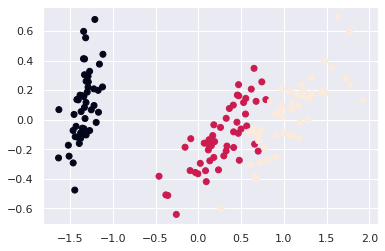

In [ ]:
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y = True)

X = (X - X.mean()) / X.std()

n, p = X.shape

n_comp = 2

pca = PCA(n_comp)

x_approx = pca.fit_transform(X)
plt.scatter(x_approx[:,0], x_approx[:, 1], c = y)

In [ ]:
u = cp.Variable((n, n_comp))
v = np.random.normal(size = (n_comp, p))

obj = cp.sum_squares(X - u @ v)

problem = cp.Problem(cp.Minimize(obj))

problem.solve()

u.value

i = 1

while True:

    # in odd cases fix u
    if i % 2 != 0:

        u = u.value
        v = cp.Variable((n_comp, p))

        #print(u)


    # in even cases fix v
    if i % 2 == 0:

        u = cp.Variable((n, n_comp))
        v = v.value

        #print(v)

    obj = cp.norm(X - u * v, 'fro')
    problem = cp.Problem(cp.Minimize(obj))
    problem.solve()

    print(problem.value)


    i += 1

    if i == 100:

        break

    




6.667556480665767
3.2997276888415596
3.0542451664750963
3.0421720895511433
3.041570811405219
3.0415403995622956
3.041538830257549
3.041538770827892
3.0415387471322752
3.0415387665822027
3.041538746915346
3.041538766571112
3.041538746914772
3.041538766571083
3.041538746914774
3.0415387665710756
3.0415387469147688
3.041538766571081
3.0415387469147825
3.041538766571073
3.041538746914792
3.041538766571088
3.0415387469147737
3.041538766571081
3.041538746914786
3.041538766571089
3.0415387469147754
3.041538766571072
3.0415387469147817
3.04153876657108
3.041538746914775
3.04153876657108
3.041538746914771
3.0415387665710867
3.041538746914782
3.041538766571082
3.041538746914773
3.0415387665710836
3.041538746914765
3.0415387665710787
3.0415387469147706
3.0415387665710747
3.041538746914767
3.0415387665710876
3.041538746914766
3.041538766571086
3.041538746914777
3.0415387665710845
3.0415387469147737
3.0415387665710707
3.041538746914772
3.041538766571072
3.0415387469147777
3.0415387665710774
3.04153

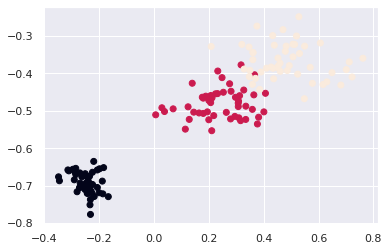

In [ ]:
plt.scatter(u[:, 0], u[:, 1], c = y)

## Sparse PCA

Let's have a look at the first row of our $U$ matrix from the IRIS example.

In [ ]:
#hide_input
u[0, :]

array([-0.25091784, -0.71055147])

All entries for that observation are nonzero, imaging we have 300 variables and reduce it down to 100. THen we would have 100 non zero entries with PCA. It might be useful if $U$ were sparse meaning alot of entries in $U$ are zero. This would even further help interpreting results. This motivateS sparse PCA. In sparse PCA we have the same loss as in PCA but this time we add some constraints namely we have

$\sum_{i=1}^n \sum_{j=1}^p (X_{ij} - (UV)_{ij})^2 \ \ \ s.t. ||U||_2 = 1 \ \ \text{and} \ \ ||U||_0 \leq k$

The first constraint helps with identifcation and the second, means that we want $K$ non zero entries for each row of our matrix $U$.

Estimating this is not easy because of the $l0$ norm. One approximation could be to use a l1 penalty ala lasso. 

$\sum_{i=1}^n \sum_{j=1}^p (X_{ij} - (UV)_{ij})^2 + \lambda ||U||_1 \ \ \ s.t. ||U||_2 = 1$

The downsaide with this approach is that we can't control the umber of non zero entries.

## K-Means

If we set $k = 1$ in Sparse PCA the nwe get K-Means clustering. In the matrix $U$ each row will have a non zero entry. The column index of this entry can be interpreted as cluster label.

The matrix V contains the cluster centroids.

Since this requires $k= 1$ I dont know how to estimate this at the moment.

## Non negative matrix factorization

Sometimes one has given a matrix which only contains non negatve entries. This could be images, bag of words,... It would be desirable to incorporate this information into matrix decomposiiotns. There are many variants on how to state the optimization problem. The most intuitive is the following

$\sum_{i=1}^n \sum_{j=1}^p (X_{ij} - (UV)_{ij})^2  \ \ \text{such that} \ \ \ U \geq 0 \ \ \text{and} \ \ V \geq 0$

## Exponential dispersion family pca

exponential dispersion pca generalizes all mentioned above. We cna think as if our data matrix was geneated by some parametrizable distribution. In other words we think of the approximation $(UV)_{ij}$ for some datapoint $x_{ij}$ as the mean of the distribution generating $x_{ij}$ for example $x_{ij} \sim N((UV)_{ij}, \sigma)$.

If our data is non negative we could choose a poisson distribution as genarting process the solution to this problem is the same as in NNMF!

### Extensions

## Simulations

## Real world example

## Applications

### Missing Value imputation

compression store only U and V and recover X with minimal loss

outlier detection, check where apprimation is bad

## Helper Functions

## Plot for the Blog Post

## References

{% bibliography --cited %}